# 稠密连接网络（DenseNet）

ResNet极大地改变了如何参数化深层网络中函数的观点。
*稠密连接网络*（DenseNet） :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`在某种程度上是ResNet的逻辑扩展。让我们先从数学上了解一下。

## 从ResNet到DenseNet

回想一下任意函数的泰勒展开式（Taylor expansion），它把这个函数分解成越来越高阶的项。在$x$接近0时，

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

同样，ResNet将函数展开为

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

也就是说，ResNet将$f$分解为两部分：一个简单的线性项和一个复杂的非线性项。
那么再向前拓展一步，如果我们想将$f$拓展成超过两部分的信息呢？
一种方案便是DenseNet。

![ResNet（左）与 DenseNet（右）在跨层连接上的主要区别：使用相加和使用连结。](../img/densenet-block.svg)
:label:`fig_densenet_block`

如 :numref:`fig_densenet_block`所示，ResNet和DenseNet的关键区别在于，DenseNet输出是*连接*（用图中的$[,]$表示）而不是如ResNet的简单相加。
因此，在应用越来越复杂的函数序列后，我们执行从$\mathbf{x}$到其展开式的映射：

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。
实现起来非常简单：我们不需要添加术语，而是将它们连接起来。
DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。
稠密连接如 :numref:`fig_densenet`所示。

![稠密连接。](../img/densenet.svg)
:label:`fig_densenet`

稠密网络主要由2部分构成：*稠密块*（dense block）和*过渡层*（transition layer）。
前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

## (**稠密块体**)

DenseNet使用了ResNet改良版的“批量规范化、激活和卷积”架构（参见 :numref:`sec_resnet`中的练习）。
我们首先实现一下这个架构。


In [10]:
import torch
# 从torch模块中导入nn（神经网络）子模块，用于构建神经网络模型。
from torch import nn
# 从d2l库中导入torch模块并重命名为d2l，用于一些辅助函数和工具。
from d2l import torch as d2l

# 定义了一个名为conv_block的函数，该函数接受输入通道数input_channels和输出通道数num_channels作为参数。
def conv_block(input_channels, num_channels):
    #  返回一个nn.Sequential对象，该对象按照顺序组合了一系列的层和操作。
    return nn.Sequential(
        # 添加批量归一化层（BatchNorm2d）和ReLU激活函数层。
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        # 添加二维卷积层（Conv2d），其中使用3x3的卷积核，padding=1表示在输入的高度和宽度两侧各添加一层填充。
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

一个*稠密块*由多个卷积块组成，每个卷积块使用相同数量的输出通道。
然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。


In [11]:
# 定义了一个名为DenseBlock的类，该类继承自nn.Module。
class DenseBlock(nn.Module):
    # 定义了DenseBlock类的初始化方法，
    # 接受num_convs（块内卷积层数）、
    # input_channels（输入通道数）
    # 和num_channels（每个卷积块的输出通道数）作为参数。
    def __init__(self, num_convs, input_channels, num_channels):
        # 调用父类nn.Module的初始化方法，确保正确地初始化DenseBlock类的实例。
        super(DenseBlock, self).__init__()
        # 创建一个空列表layer，用于存储每个卷积块的层。
        layer = []
        # 通过循环，根据num_convs的值迭代创建卷积块的层。
        for i in range(num_convs):
            # 将每个卷积块的层添加到layer列表中。
            # 每个卷积块的输入通道数为num_channels * i + input_channels，输出通道数为num_channels。
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        #  使用nn.Sequential将所有卷积块的层组合成一个顺序容器，并将其存储为DenseBlock类的属性self.net。
        self.net = nn.Sequential(*layer)

    # 定义了DenseBlock类的前向传播方法，接受输入张量X作为参数。
    def forward(self, X):
        # 遍历self.net中的每个卷积块
        for blk in self.net:
            # 将输入张量X传递给当前卷积块blk，并将输出结果存储在Y中。
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            # 将输入张量X和当前卷积块的输出张量Y在通道维度上进行拼接，将它们连接起来。
            X = torch.cat((X, Y), dim=1)
        # 返回最终的张量X作为DenseBlock的输出。
        return X

在下面的例子中，我们[**定义一个**]有2个输出通道数为10的(**`DenseBlock`**)。
使用通道数为3的输入时，我们会得到通道数为$3+2\times 10=23$的输出。
卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为*增长率*（growth rate）。


In [12]:
# 在给定的代码中，
# 创建了一个DenseBlock实例blk，其中num_convs为2，input_channels为3，num_channels为10。
# 然后，使用随机生成的输入张量X（大小为[4, 3, 8, 8]）对DenseBlock进行前向传播操作。
# 根据DenseBlock的定义，它由两个卷积块组成。
# 每个卷积块接收输入张量并进行一系列的卷积操作和拼接操作。
# 在每个卷积块内部，输入通道数会随着块的迭代次数增加而增加，以便在每个块中保留之前所有块的特征信息。
blk = DenseBlock(2, 3, 10)
# 通过对输入张量X进行DenseBlock的前向传播操作，得到了输出张量Y。
# 根据给定的输入大小和DenseBlock的定义，输出张量Y的形状为[4, 3 + 10 * 2, 8, 8]，
# 其中通道维度的大小为3 + 10 * 2，表示输入通道数加上两个卷积块中每个块的输出通道数的累积。
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## [**过渡层**]

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。
而过渡层可以用来控制模型复杂度。
它通过$1\times 1$卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。


In [13]:
# 函数 transition_block 是一个用于构建 DenseNet 中的过渡层（Transition Block）的函数，其具体功能如下：
# input_channels：输入特征图的通道数。
# num_channels：过渡层输出特征图的通道数。
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        # 函数中的 nn.BatchNorm2d 用于对输入特征图进行批量归一化操作，以加速网络的收敛和提升模型的泛化能力。
        # 接下来的 nn.ReLU 是一个激活函数，用于引入非线性性质。
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        # 紧接着是一个 nn.Conv2d 卷积层，将输入特征图的通道数从 input_channels 减少到 num_channels。
        # 这里使用了 kernel_size=1 的卷积核，即 1x1 卷积，它用于降低特征图的维度。
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        # 最后，通过 nn.AvgPool2d 平均池化层对特征图进行下采样，将特征图的空间尺寸缩小一半。
        # 这里使用了 kernel_size=2 和 stride=2 的平均池化操作。
        nn.AvgPool2d(kernel_size=2, stride=2))

对上一个例子中稠密块的输出[**使用**]通道数为10的[**过渡层**]。
此时输出的通道数减为10，高和宽均减半。


In [14]:
# 根据给定的输入 Y 和过渡层的参数，可以计算出过渡层的输出形状。
# 假设 Y 的形状为 (batch_size, input_channels, height, width)，过渡层的输出形状可以通过前向传播计算得到。
# 下面给出具体的计算过程：
# 输入 Y 经过批量归一化、激活函数、1x1 卷积和平均池化操作后，会产生输出特征图。
# 平均池化操作将特征图的高度和宽度缩小一半，同时保持通道数不变。
# 因此，过渡层的输出形状为 (batch_size, num_channels, height/2, width/2)
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## [**DenseNet模型**]

我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。


In [15]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。
与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。
这里我们设成4，从而与 :numref:`sec_resnet`的ResNet-18保持一致。
稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。


In [16]:
# num_channels为当前的通道数
# 上述代码是在 DenseNet 中创建多个 Dense Block 和相应的转换层。具体解析如下：
# num_channels 和 growth_rate：定义了初始的通道数和每个稠密块中的通道增长率。
num_channels, growth_rate = 64, 32
# num_convs_in_dense_blocks：定义了每个稠密块中的卷积层数量，是一个列表。
num_convs_in_dense_blocks = [4, 4, 4, 4]
# 这是一个空列表，用于存储 Dense Block 和转换层
blks = []
# for 循环：对于每个稠密块的卷积层数量 num_convs，进行以下操作：
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    # 创建一个 Dense Block，并将其添加到 blks 列表中。
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    # 更新 num_channels，增加当前稠密块的输出通道数。
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    # 判断是否需要添加转换层：
    # 如果不是最后一个稠密块，调用转换层函数 transition_block，将当前的通道数减半，并将其添加到 blks 列表中。
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        # 更新 num_channels，使其成为转换层后的通道数。
        num_channels = num_channels // 2
# 这样，通过循环迭代，可以构建出一个包含多个 Dense Block 和转换层的列表 blks，用于构建 DenseNet 网络。
# 请注意，这段代码只是创建了 Dense Block 和转换层的列表，并没有构建完整的 DenseNet 网络。
# 要构建完整的 DenseNet 网络，还需要将这些层按照顺序添加到顺序容器中，如前面所示的 net 定义。

与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。


In [17]:
net = nn.Sequential(
    
    # b1：这是一个包含初始卷积层、批量归一化层和激活函数的顺序容器，用于处理输入数据。
    # *blks：这是一个展开的列表，其中包含多个 Dense Block 和转换层。
    #  在 Dense Block 中，通过连接多个具有相同输入通道数的稠密块，从而增加通道数和特征图的维度。
    b1, *blks,
    # nn.BatchNorm2d(num_channels)：这是一个批量归一化层，用于对最后一个 Dense Block 的输出进行归一化操作。
    # nn.ReLU()：这是一个激活函数，对归一化后的输出进行激活。
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    # nn.AdaptiveAvgPool2d((1, 1))：这是一个自适应平均池化层，将特征图的大小调整为 (1, 1)。
    nn.AdaptiveAvgPool2d((1, 1)),
    # nn.Flatten()：这是一个将多维特征图展平为一维向量的操作。
    nn.Flatten(),
    # 这是一个全连接层，将展平后的特征向量映射到输出类别的数量。
    nn.Linear(num_channels, 10))

# 最终，这些层按照顺序添加到顺序容器 net 中，构成了一个完整的 DenseNet 网络。

## [**训练模型**]

由于这里使用了比较深的网络，本节里我们将输入高和宽从224降到96来简化计算。


loss 0.276, train acc 0.902, test acc 0.862
5772.1 examples/sec on cuda:0


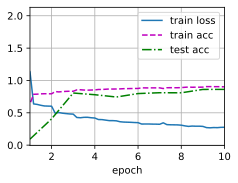

: 

In [18]:
# 这段代码使用加载的 Fashion-MNIST 数据集，以批量大小为 256 进行训练和测试，使用学习率为 0.1 进行训练，共进行 10 个 epochs 的训练。
lr, num_epochs, batch_size = 0.1, 10, 256
# lr, num_epochs, batch_size = 0.1, 10, 25600

# lr, num_epochs, batch_size = 0.1, 10, 2560
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 在跨层连接上，不同于ResNet中将输入与输出相加，稠密连接网络（DenseNet）在通道维上连结输入与输出。
* DenseNet的主要构建模块是稠密块和过渡层。
* 在构建DenseNet时，我们需要通过添加过渡层来控制网络的维数，从而再次减少通道的数量。

## 练习

1. 为什么我们在过渡层使用平均汇聚层而不是最大汇聚层？
1. DenseNet的优点之一是其模型参数比ResNet小。为什么呢？
1. DenseNet一个诟病的问题是内存或显存消耗过多。
    1. 真的是这样吗？可以把输入形状换成$224 \times 224$，来看看实际的显存消耗。
    1. 有另一种方法来减少显存消耗吗？需要改变框架么？
1. 实现DenseNet论文 :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`表1所示的不同DenseNet版本。
1. 应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于 :numref:`sec_kaggle_house`中的房价预测任务。


[Discussions](https://discuss.d2l.ai/t/1880)
